<a href="https://colab.research.google.com/github/Buzzrightear/CO885_dissertation/blob/master/RandomForrest3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive
"""

'\n# Mount Google Drive\nfrom google.colab import drive # import drive from google colab\n\nROOT = "/content/drive"     # default location for the drive\nprint(ROOT)                 # print content of ROOT (Optional)\n\ndrive.mount(ROOT)           # we mount the google drive at /content/drive\n'

In [2]:
# Most code and guidance taken from https://colab.research.google.com/drive/1WJjty6Q87WZeqBZVy6--cgrnuW4p50PP#scrollTo=1iEXEPxRNNUX 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/Buzzrightear/CO885_dissertation/master/wind_data_3.csv', parse_dates=['Date time']) #Read in csv to dataframe
df=df[['Date time', 'Wind min','Wind avg', 'Wind max', 'Power min', 'Power avg', 'Power max', 'Wind dir' ]].dropna() # reduce dataframe to just 2 columns and drop any blank rows

print(df.head())
print(df.shape[0])


            Date time  Wind min  Wind avg  ...  Power avg  Power max  Wind dir
0 2011-09-01 00:10:00       5.5       5.4  ...       78.0       83.0     185.0
1 2011-09-01 00:20:00       5.2       5.3  ...       77.0       81.0     185.0
2 2011-09-01 00:30:00       5.1       5.0  ...       72.0       83.0     185.0
3 2011-09-01 00:40:00       4.9       4.9  ...       70.0       77.0     186.0
4 2011-09-01 00:50:00       4.8       4.8  ...       62.0       78.0     190.0

[5 rows x 8 columns]
223300


**train_forest** takes a data frame, splits it into training and validation sets (based on a given number of records for the validation set), and fits a random forest.

**check_predictions** sets up a 2x2 grid for subplots, and calls predictions_plot for all training and validation results, plus the last week of the training set and the first week of the validation set. The theory is that the Random Forest's accuracy will degrade as the electrical system changes (e.g. additional rooftop solar capacity changes the relationship of sunny days) - but it should be more accurate in the short term.

**predictions_plot** calculates mean absolute error and maximum absolute error, then plots the results

**UPDATE**: The results are almost perfect on the training set, but the Random Forest is a flat line in the validation set because the decision trees can't extrapolate a datetime.

So let's try information we can derive from Trading Interval: hour (plus a .5 for the half hour intervals), day of the week, and month of the year. We'll redefine train_forest and predictions_plot to drop Trading Interval itself as an explanatory variable because it's just going to result in overfitting:

In [4]:
#Run this when starting runtime env for first time. Only needs doing once - then comment out or don't run

#Changing features to an hour, month, year and day  column, to give the RF some info on months and time of day, where wind patterns could be identified 
df.insert(len(df.columns), 'Hour', df['Date time'].dt.hour + df['Date time'].dt.minute/60)
df.insert(len(df.columns), 'Month', df['Date time'].dt.month)
df.insert(len(df.columns), 'year', df['Date time'].dt.year)
df.insert(len(df.columns), 'day', df['Date time'].dt.day)


            Date time  Wind min  Wind avg  Wind max  Power min  Power avg  \
0 2011-09-01 00:10:00       5.5       5.4       6.0       74.0       78.0   
1 2011-09-01 00:20:00       5.2       5.3       5.9       73.0       77.0   
2 2011-09-01 00:30:00       5.1       5.0       5.8       64.0       72.0   
3 2011-09-01 00:40:00       4.9       4.9       6.0       65.0       70.0   
4 2011-09-01 00:50:00       4.8       4.8       5.8       55.0       62.0   

   Power max  Wind dir      Hour  Month  year  day  
0       83.0     185.0  0.166667      9  2011    1  
1       81.0     185.0  0.333333      9  2011    1  
2       83.0     185.0  0.500000      9  2011    1  
3       77.0     186.0  0.666667      9  2011    1  
4       78.0     190.0  0.833333      9  2011    1  
223300


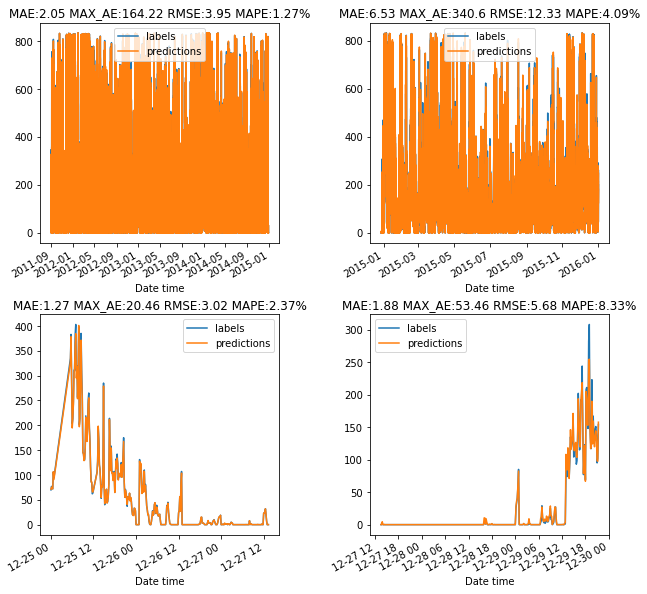

In [5]:
SPLIT_POINT = 144*365 #Asjust this to change size of test set. The last year's worth of entries are reserved as a validation set (144 entries per day * 365 days)

def train_forest(df, split_point):
  train_features = df.drop(['Power avg'], axis = 1).head(df.shape[0]-split_point)   #Get rid of the 'Power avg' columns inc. column heading and keep all rows up to split_point
  train_labels = df['Power avg'].head(df.shape[0]-split_point)                      #Just return 'Power avg' column without col heading up to split-point
  #train_labels = df['Power avg'].head(len(df)-split_point)                      #Just return 'Power avg' column without col heading up to split-point
  val_features = df.drop(['Power avg'], axis = 1).tail(split_point)             #Get rid of the 'Power avg' columns inc. column heading and keep all rows after split_point
  val_labels = df['Power avg'].tail(split_point)                                #Just return 'Power avg' column without col heading after split-point

  rf = RandomForestRegressor(n_estimators = 50, random_state = 42)
  rf.fit(train_features.drop('Date time', axis=1), train_labels)  #Train RF on training features (dates) and target classifcations / labels (power avg values)

  return [rf, train_features, train_labels, val_features, val_labels]

def check_predictions(rf, train_features, train_labels, val_features, val_labels):
  fig,axes  = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
  fig.tight_layout(pad=6.0)
  predictions_plot(rf, train_features, train_labels, axes[0,0]) #Predictions based on the training set of dates (should be v accurate)
  predictions_plot(rf, val_features, val_labels, axes[0,1]) #Predictions based on the test set of dates (should be quite inaccurate)
  predictions_plot(rf, train_features.tail(7*48), train_labels.tail(7*48), axes[1,0]) #Predictions based on the final week of training set of dates (should be v accurate)
  predictions_plot(rf, val_features.head(7*48), val_labels.head(7*48), axes[1,1]) #Predictions based on the first week of test set of dates (should be quite inaccurate)

def predictions_plot(rf, features, labels, ax):
  EPSILON =  1e-10  #1e-10 - Very small constant added to every entry to ensure no values of actual zero - this avoids zero division error on calculation of MAPE
  predictions = rf.predict(features.drop('Date time', axis=1)) # Each call to this function just gives a set of features (dates) as a param and returns a dataframe of 'labels' (power avg values)
  errors = abs(predictions - labels) #predicted values numpy array minus actual values numpy array returns numpy array 'errors'
  
  #Figuring out MAPE:
  """ 
  print("Labels plus EPSILON: ", labels[:5]+EPSILON)
  print("Mean of Labels plus EPSILON: ", np.mean(labels[:5]+EPSILON))
  print("predictions: /n", predictions[:5])
  print("Errors: /n" , errors[:5])
  print("Labels: /n" , labels[:5])
  #print("errors / abs(labels)/n" , errors[:5]/abs(labels[:5]))
  #print("Mean of errors / abs(labels)/n" , np.mean(errors[:5]/abs(labels[:5])))
  #print("As a %: Mean of errors / abs(labels)/n" , np.mean(errors[:5]/abs(labels[:5]))*100)
  print("As a %: Mean of errors / abs(labels)/n" , np.mean(errors[:5]/abs(labels[:5])+EPSILON)*100)
  print("Rounded As a %: Mean of errors / abs(labels)/n" , round(np.mean(errors[:5]/abs(labels[:5])+EPSILON)*100,2))
  """

  # MAE = mean abs error; MAX_AE = max absolute error (largest single error in prediction by rf); RMSE = Root Mean Square Error (gets rid of negatives and more sensitive to large errors than MAPE);
  # MAPE = mean absolute percentage error (MAPE is a straightforward measure of the prediction accuracy of a forecasting method, and is thus usually considered as the fairest indicator https://www.mdpi.com/2071-1050/12/6/2247/htm#B37-sustainability-12-02247)
  title='MAE:' + str(round(np.mean(errors), 2)) + \
        ' MAX_AE:' + str(round(np.max(abs(errors)), 2)) + \
        ' RMSE:' + str(round(np.sqrt(np.mean(np.square(errors))), 2)) + \
        ' MAPE:' + str(round(((np.mean(errors)/np.mean((abs(labels+EPSILON))))*100),2)) + "%" # https://www.mdpi.com/2071-1050/12/6/2247/htm  Doesn't really work when you have zero values, which we do because sometimes the wind doesn't blow

  #Create dataframe comprising three elements: 'labels' (actual Power avg values), 'predictions' (predicted 'power avg' values), 'features' (Date time values) and then plot them
  pd.DataFrame({'labels': labels, 
                'predictions': predictions, 
                'Date time': features['Date time']}).plot(title=title, ax=ax, x='Date time')


pd.set_option('display.max_columns', None)
#pd.reset_option('max_columns')
print(df.head())
print(df.shape[0])

[rf, train_features, train_labels, val_features, val_labels] = train_forest(df, SPLIT_POINT) 
check_predictions(rf, train_features, train_labels, val_features, val_labels) 

51188


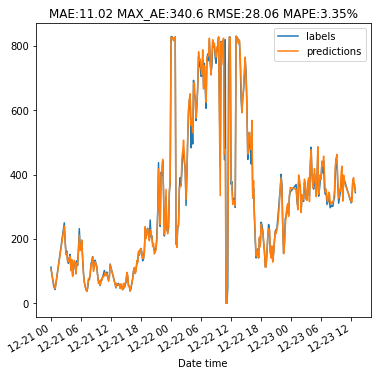

In [6]:
#Look at the week of the worst error

abs_errors = abs(rf.predict(val_features.drop(['Date time'], axis=1)) - val_labels)
worst_index = abs_errors.tolist().index(max(abs_errors))
print(worst_index)
fig,axes  = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
predictions_plot(rf, val_features.head(worst_index + 3*48).tail(7*48), val_labels.head(worst_index + 3*48).tail(7*48), axes)
